In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm
import pickle

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]

In [269]:
experiment_id_idx = 0
experiment_id = experiment_ids[experiment_id_idx]

In [270]:
model = torch.load(f'saved/{experiment_id}_wd_0.0.pt', weights_only=False, map_location='cpu')

In [271]:
with open('./saved/wildtypes_sites.pkl', 'rb') as f:
    wts = pickle.load(f)

wt = wts[experiment_id_idx]
wt_oh = utils.one_hot(wt)
L = 45
q = 4

In [272]:
def hamming(x, y):
    L = x.size(-1)
    return (x != y).sum(dim=(-1))

In [273]:
def sequences_at_distance_1(wt):
    seq = []
    for i in range(L):
        delta = torch.zeros(L)
        # use itertools.product here to generalize to distance d
        for a in range(1, q):
            delta[i] = a
            s = torch.fmod(delta+wt, q)
            seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 1)
    return neigs

In [274]:
def sequences_at_distance_2(wt):
    seq = []
    for i in range(L):
        for j in range(L):
            if j != i:
                delta = torch.zeros(L)
                for a in range(1, q):
                    delta[i] = a
                    for b in range(1, q):
                        delta[j] = b
                        s = torch.fmod(delta+wt, q)
                        seq.append(s)
    neigs = torch.stack(seq).to(dtype=torch.int)
    assert torch.all(hamming(wt, neigs) == 2)
    return neigs

In [296]:
def plot_hist(model, wt, neigs, **kwargs):
    neighbors_oh = utils.one_hot(neigs)
    logps_neigs = - model.selection_energy_at_round(neighbors_oh, 1).detach()
    logps_wt = - model.selection_energy_at_round(wt_oh, 1).detach()
    fig, ax = plt.subplots(**kwargs)
    ax.hist(logps_neigs, bins=100, density=True)
    ax.axvline(x=logps_wt.item(), color='red', label="wildtype")
    ax.set_xlabel('logps'); ax.set_ylabel('frequency')
    ax.legend()
    return logps_neigs, logps_wt, fig, ax

In [297]:
neighbors_1 = sequences_at_distance_1(wt)
neighbors_2 = sequences_at_distance_2(wt)

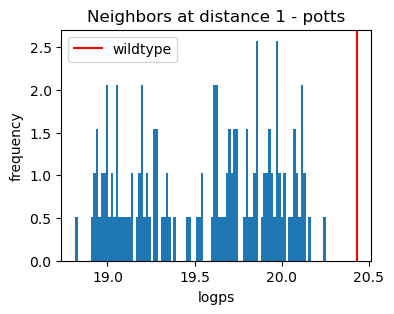

In [298]:
logps_neigs_1_potts, logps_wt_1_potts, fig, ax = plot_hist(model, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - potts');

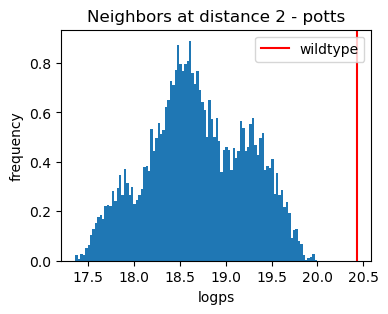

In [299]:
logps_neigs_2_potts, logps_wt_2_potts, fig, ax = plot_hist(model, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - potts');

In [300]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')

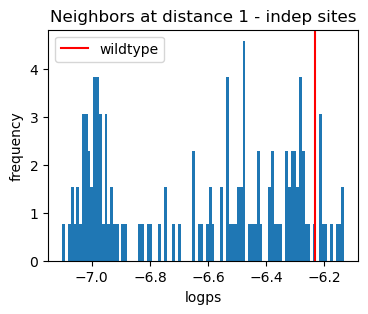

In [301]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_1, figsize=(4,3))
ax.set_title('Neighbors at distance 1 - indep sites');

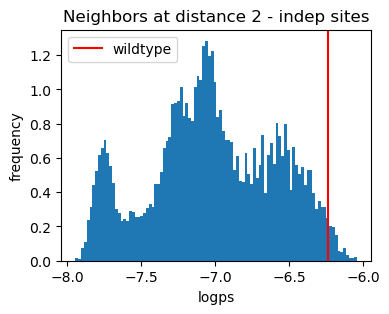

In [302]:
logps_neigs_1_indep, logps_wt_1_indep, fig, ax = plot_hist(model_indep, wt, neighbors_2, figsize=(4,3))
ax.set_title('Neighbors at distance 2 - indep sites');

In [213]:
# filepath = f'/home/scrotti/Aptamer2025py/experiments/saved/pseudocount/indep_sites/{experiment_id}_0.00000000.pkl'
# with open(filepath, 'rb') as f:
#     params = pickle.load(f)[2]

# tr = tree.Tree()
# tr.add_node(-1, name = "R01")
# tr.add_node(0, name = "R02N")

# selected_modes = torch.BoolTensor(
#     [[1], [1]]
# )

# Ns0 = energy_models.IndepSites(params['bias_Ns0'])

# ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(params['bias_ps']), normalized=False)
# model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

# torch.save(model, f'saved/{experiment_id}_indep_sites.pt')